In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Load the data (replace with your actual file path)
df = pd.read_csv('train_FD001_phase_1.csv')

# Initial data cleaning (NOTE: Engine no is dropped here)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop(["Engine no"] + [f"Operating {i}" for i in range(1, 4)] + [f"Sensor {i}" for i in [1, 5, 6, 10, 16, 18, 19]], axis=1)


In [3]:
df.head()


,Num cycles,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 8,Sensor 9,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Stage
0,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,0
1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,0
2,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,0
3,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,0
4,6,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,2388.03,8132.85,8.4108,391,38.98,23.3669,0


In [4]:
def compute_avg_time_to_next_stage(df):
    df = df.sort_values(['Num cycles'])  # Sort by cycles (important!)
    df['time_to_next_stage'] = np.nan

    avg_time_to_next = {}
    for stage in df['Stage'].unique():
        next_stage = stage + 1
        if next_stage in df['Stage'].unique():
            stage_indices = df[df['Stage'] == stage].index
            next_stage_indices = df[df['Stage'] == next_stage].index
            if not stage_indices.empty and not next_stage_indices.empty:
                avg_time = np.mean([df['Num cycles'][j] - df['Num cycles'][i]
                                    for i in stage_indices
                                    for j in next_stage_indices if df['Num cycles'][j] > df['Num cycles'][i]])
                avg_time_to_next[stage] = avg_time

    for i in df.index:
        current_stage = df.loc[i, 'Stage']
        if current_stage in avg_time_to_next:
            df.loc[i, 'time_to_next_stage'] = avg_time_to_next[current_stage]

    return df

df = compute_avg_time_to_next_stage(df)
df = df.fillna(0)  # Handle potential NaNs
print("Average time to next stage calculated (WITHOUT Engine no).")

Average time to next stage calculated (WITHOUT Engine no).


In [5]:
# Feature Engineering
for sensor in [f'Sensor {i}' for i in range(2, 22) if f'Sensor {i}' in df.columns]:
    df[f'{sensor}_rolling_mean_10'] = df[sensor].rolling(window=10, min_periods=1).mean()
    df[f'{sensor}_diff'] = df[sensor].diff()
    df[f'{sensor}_lag_1'] = df[sensor].shift(1)

df = df.fillna(0)
print("Feature engineering done (WITHOUT Engine no - CAUTION!).")

Feature engineering done (WITHOUT Engine no - CAUTION!).


In [6]:
# Data Preprocessing: Scaling
numerical_cols = [col for col in df.columns if df[col].dtype != 'object' and col not in ['Num cycles', 'time_to_next_stage', 'Stage']]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Data scaled.")

Data scaled.


In [7]:
# Data Preparation for Modeling
X = df.drop(['time_to_next_stage', 'Num cycles', 'Stage'], axis=1)
y = df['time_to_next_stage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data prepared for modeling.")

Data prepared for modeling.


RMSE: 10.692059207011807, MAE: 6.1580540620438615, R-squared: 0.8147273893541264


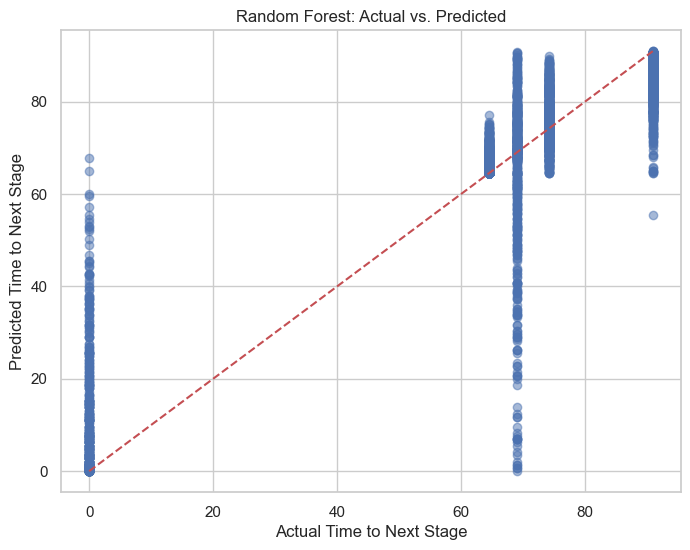

In [17]:
# Model: Random Forest Regressor (Basic)
rf = RandomForestRegressor(random_state=42)  # Basic parameters
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


print(f"RMSE: {rmse_rf}, MAE: {mae_rf}, R-squared: {r2_rf}")

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal prediction line
plt.xlabel("Actual Time to Next Stage")
plt.ylabel("Predicted Time to Next Stage")
plt.title("Random Forest: Actual vs. Predicted")
plt.show()

In [13]:
# Model: Ridge Regression (Basic)
ridge = Ridge(random_state=42)  # Basic parameters
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Trained (Basic)")

print(f"RMSE: {rmse_ridge}, MAE: {mae_ridge}, R-squared: {r2_ridge}")
print("The reason we get such a bad value of R-Squared is because of the skewness of the target value")

Ridge Regression Trained (Basic)
RMSE: 21.817725524486793, MAE: 17.31151679745226, R-squared: 0.22855057642629228
The reason we get such a bad value of R-Squared is because of the skewness of the target value


RMSE: 11.509090335493678, MAE: 6.765184097075071, R-squared: 0.7853304188545522


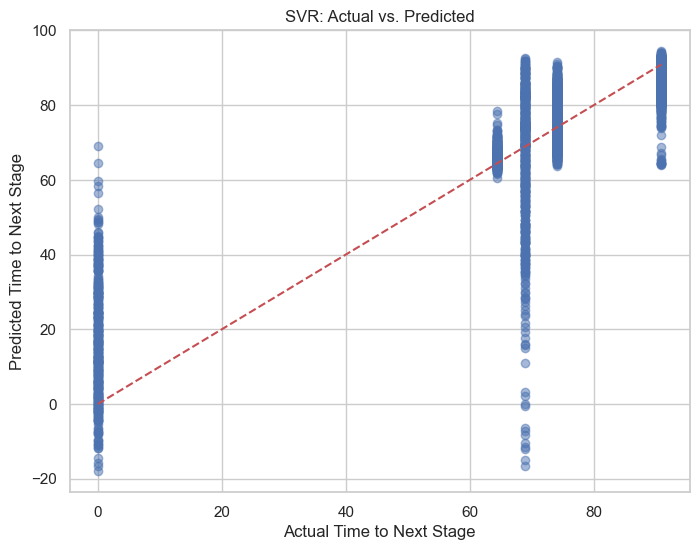

In [16]:
# Model: Support Vector Regression (SVR) (Basic)
svr = SVR()  # Basic parameters
svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)


print(f"RMSE: {rmse_svr}, MAE: {mae_svr}, R-squared: {r2_svr}")
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal prediction line
plt.xlabel("Actual Time to Next Stage")
plt.ylabel("Predicted Time to Next Stage")
plt.title("SVR: Actual vs. Predicted")
plt.show()

In [14]:
# Model Comparison
print("\nModel Comparison:")
print(f"Random Forest - RMSE: {rmse_rf}, MAE: {mae_rf}, R-squared: {r2_rf}")
print(f"Ridge Regression - RMSE: {rmse_ridge}, MAE: {mae_ridge}, R-squared: {r2_ridge}")
print(f"SVR - RMSE: {rmse_svr}, MAE: {mae_svr}, R-squared: {r2_svr}")


Model Comparison:
Random Forest - RMSE: 10.692059207011807, MAE: 6.1580540620438615, R-squared: 0.8147273893541264
Ridge Regression - RMSE: 21.817725524486793, MAE: 17.31151679745226, R-squared: 0.22855057642629228
SVR - RMSE: 11.509090335493678, MAE: 6.765184097075071, R-squared: 0.7853304188545522
